In [2]:
try:
    del sys.modules["pgm"]
except:
    pass
try:
    del sys.modules["lgpgm"]
except:
    pass
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
from pgm import Distribution as dist, ParentList as pa
from lgpgm import Norm, noise
import spnhelp

from spn.structure.Base import get_number_of_nodes, get_depth
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import likelihood 
import scipy.stats as stats
import torch
from IPython.display import display

### Developing a nice PGM syntax
It's a graph. We build it from the root.
 - Roots just needs their distribution and a name.
 - The rest needs its conditional distribution given its parents, its parents, and a name

In [3]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up

def t (depth, power, factor,  start):
    if depth == -1:
        return start
    t2 = (depth + 1) ** power
    t5 = depth ** power
    return(1 / (factor * t5 + start) * (factor * t2 + start))




\begin{align*}
    \texttt{gauss}(mean,sd)(x) &\propto \mathcal{N}(mean, sd)(x)\\
    \texttt{cond\_linear\_gauss}(mean,sd,pws)(x) &\propto \mathcal{N}(mean + pws^\intercal Pa(X), sd)(x)\\
    \texttt{laplace}(mean,sd)(x) &\propto \mathcal{Laplace}(mean, sd)(x)\\
    \texttt{cond\_linear\_laplace}(mean,sd,pws)(x) &\propto \mathcal{Laplace}(mean + pws^\intercal Pa(X), sd)(x)\\
    \texttt{uniform}(start,end)(x) &\propto \mathcal{U}(start;end)(x)\\
    \texttt{cond\_uniform}(start,pws)(x) &\propto \mathcal{U}(start; 0.1 + \text{abs}(pws^\intercal Pa(X)))(x)\\
\end{align*}

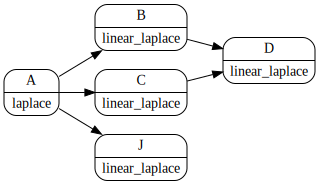

built spns
6249
6249


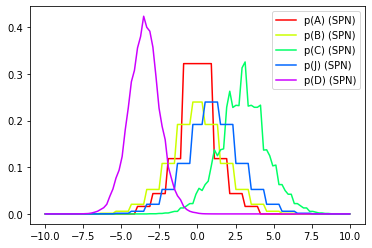

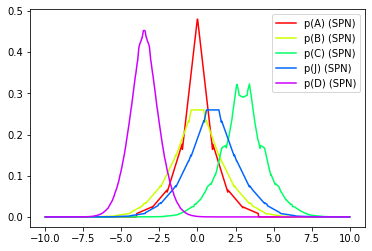

In [4]:
def gauss(mean, sd): 
    func = lambda _, x: torch.exp(-0.5*((x-mean)/sd)**2)
    bounds = lambda _: (mean - 4*sd, mean + 4*sd)
    return dist(func, bounds)
    
def cond_linear_gauss(mean, sd, pws): 
    pws = torch.tensor(pws)
    func = lambda Ps, x: torch.exp(-0.5*((x-mean-torch.sum(Ps * pws))/sd)**2)
    bounds = lambda Ps: (mean + torch.sum(Ps * pws) - 4*sd, mean + torch.sum(Ps * pws) + 4*sd)
    return dist(func, bounds, "linear_gauss")

def laplace(mean, sd):
    func = lambda _, x: torch.exp(-torch.abs(x-mean)/sd)
    bounds = lambda _: (mean - 4*sd, mean + 4*sd)
    return dist(func, bounds, "laplace")

def cond_linear_laplace(mean, sd, pws): 
    pws = torch.tensor(pws)
    func = lambda Ps, x: torch.exp(-torch.abs(x-mean-torch.sum(Ps * pws))/sd)
    bounds = lambda Ps: (mean + torch.sum(Ps * pws) - 4*sd, mean + torch.sum(Ps * pws) + 4*sd)

    return dist(func, bounds, "linear_laplace")

def uniform(a, b):
    func = lambda Ps, x: torch.where((a <= x) & (x <= b), (b - a), torch.zeros_like(x))
    bounds = (a,b)
    return dist(func, bounds, "uniform")

def cond_uniform(a):
    def func(Ps, x, a=a):
        a,b = a, a+torch.abs(torch.sum(Ps)) + 0.1
        return torch.where((a <= x) & (x <= b), (b - a), torch.zeros_like(x))
    def bounds(Ps, a=a):
        a,b = a, a+np.abs(np.sum(Ps)) + 0.1
        return a,b
    
    return dist(func, bounds, "cond_uniform")

A = "A" > laplace(mean=0.0,sd=1)
J = "J" | pa(A) > cond_linear_laplace(mean=1.0, sd= 1.0, pws=[-1.0])
B = "B" | pa(A) > cond_linear_laplace(mean=0.0, sd= 1.0, pws=[1.0])
C = "C" | pa(A) > cond_linear_laplace(mean=3, sd= 0.7, pws=[1])
D = "D" | pa(B, C) > cond_linear_laplace(mean=-2, sd=0.5, pws=[0.5, -0.5])

display(A.get_graph(True))

spn_straight = spnhelp.bn_to_spn(A, marginal_target= 8, a=1, sloped=False)
spn_sloped = spnhelp.bn_to_spn(A, marginal_target= 8, a=1, sloped=True)
# # display(spnhelp.get_spn_graph(spn, A))
spnhelp.plot_marginals(spn_straight,A, xs=np.linspace(-10, 10, 100))
spnhelp.plot_marginals(spn_sloped,A, xs=np.linspace(-10, 10, 1000))
print("built spns")
print(get_number_of_nodes(spn_straight))
print(get_number_of_nodes(spn_sloped))

\begin{align*}
    P(A, J, B, C, D) &=  P(A) \cdot P(J | A) \cdot P(B | A) \cdot P(C | A) \cdot P(D | B,C)    \\
    &\approx \Big( \sum_{a\in split(A)} U(a) \cdot \Big(\sum_{j\in split(J)}  U(j) \Big) \cdot  \Big(\sum_{b,c\in split(B, C)} U(b) \cdot U(c) \cdot \Big(\sum_{d\in split(D)}  U(d)\Big)\Big) \Big)
\end{align*}

### Comparing the SPN generated from the closed form solution with the one generated from the PGM

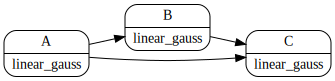

built clg_spn
built pgm_spn


Text(0.5, 1.0, 'BN $\\to$ spn')

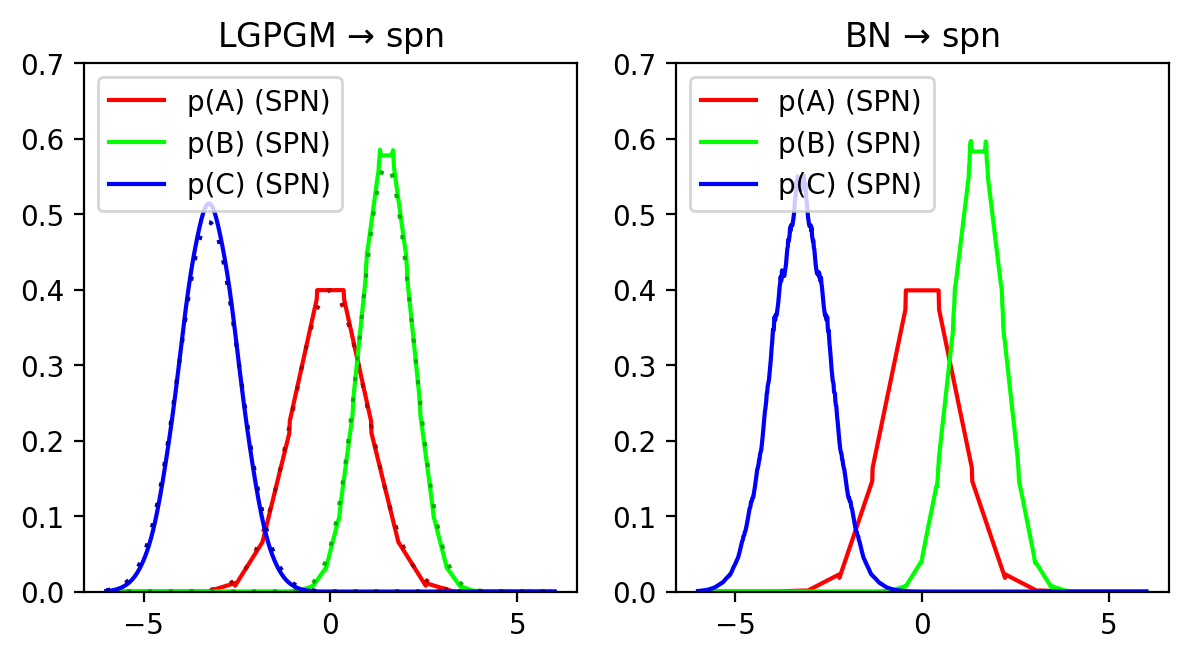

In [14]:
lg_A = "A" @ noise
lg_B = "B" @ (0.5*lg_A + 0.5*noise + 1.5)
lg_C = "C" @ (0.5*lg_A + 0.5*lg_B + 0.2*noise - 4)

# bn_A = "A" > gauss(0,1)
bn_A = "A" > cond_linear_gauss(mean=0.0, sd=1, pws=[])
bn_B = "B" |  pa(bn_A) > cond_linear_gauss(mean=1.5, sd=0.5, pws=[0.5])
bn_C = "C" |  pa(bn_A, bn_B) > cond_linear_gauss(mean=-4, sd=0.2, pws=[0.5, 0.5])

display(bn_A.get_graph())

lg_spn = spnhelp.lgpgm_to_spn(lg_A, crit_param = 9, crit=spnhelp.CRIT_even_partition, sloped=True)
print("built clg_spn")
bn_spn = spnhelp.bn_to_spn(bn_A, marginal_target= 9, sloped=True)
print("built pgm_spn")

fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
# share y axis:
axs[0].set_ylim([0, 0.7])
axs[1].set_ylim([0, 0.7])

spnhelp.plot_marginals(lg_spn, lg_A, xs=np.linspace(-6, 6, 1000), ax=axs[0])
spnhelp.plot_marginals(bn_spn, bn_A, xs=np.linspace(-6, 6, 1000), ax=axs[1])
axs[0].set_title(r"LGPGM $\to$ spn")
axs[1].set_title(r"BN $\to$ spn")

In [6]:
print("clg_spn:", get_number_of_nodes(lg_spn, node_type=Product), get_depth(lg_spn))
print("pgm_spn:", get_number_of_nodes(bn_spn, node_type=Product), get_depth(bn_spn))

clg_spn: 90 5
pgm_spn: 90 6


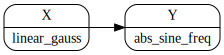

2651


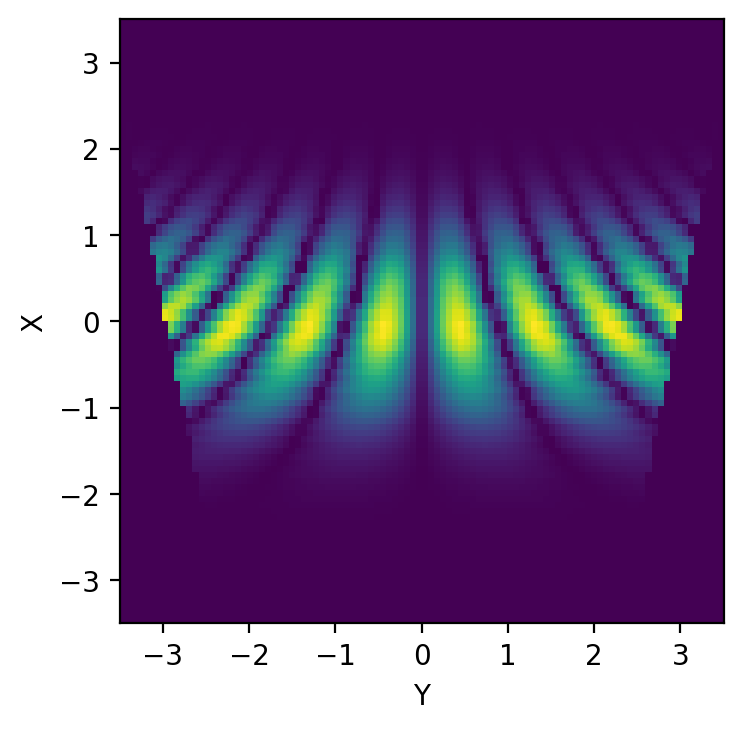

In [7]:
plt.rcParams["figure.dpi"] = 200

def uniform(a, b):
    func = lambda Ps, x: torch.where((a <= x) & (x <= b), x*0 + torch.subtract(b, a), torch.zeros_like(x))
    bounds = (a,b)
    return dist(func, bounds, "uniform")

def cond_abs_sine(pws):
    def func(Ps, x):
        a,b = -3 + pws[0]*Ps[0], 3 - pws[0]*Ps[0]
        freq = 0.1*(Ps[0]+6)**2
        # return torch.where((a <= x) & (x <= b), torch.Tensor(x), torch.zeros_like(x))
        return torch.where((a <= x) & (x <= b), torch.abs(torch.sin(freq*x)), torch.zeros_like(x))
    
    def bounds(Ps):
        # print(Ps)
        a,b = -3 + pws[0]*Ps[0], 3 - pws[0]*Ps[0]
        return a,b
    
    return dist(func, bounds, "abs_sine_freq")


X = "X" > cond_linear_gauss(0,0.7,pws=[])
Y = "Y" | pa(X) > cond_abs_sine([-0.2])


display(X.get_graph(True))


spn_sloped = spnhelp.bn_to_spn(X, marginal_target= 50, sloped=True)
info = spnhelp.get_pdf_grid_values(spn_sloped, [7, 7], [0,0], 100)
spnhelp.show_data(info)

print(get_number_of_nodes(spn_sloped))

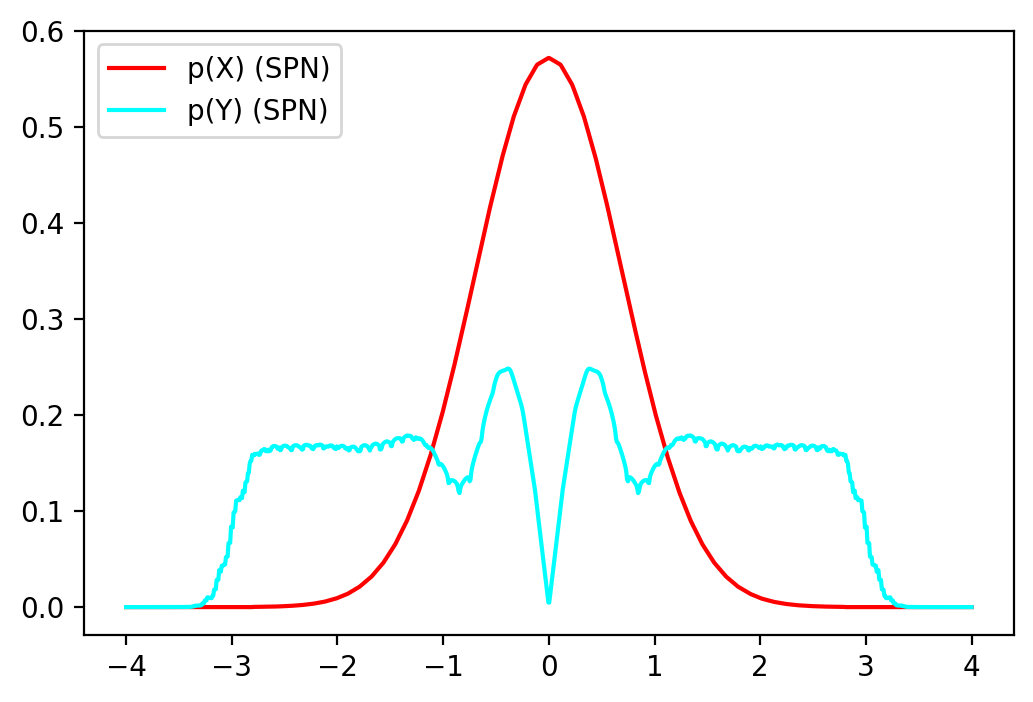

In [8]:
spnhelp.plot_marginals(spn_sloped, X, xs=np.linspace(-4, 4, 1000))
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (3,3)
plt.legend(loc="upper left")

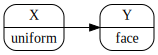

10301


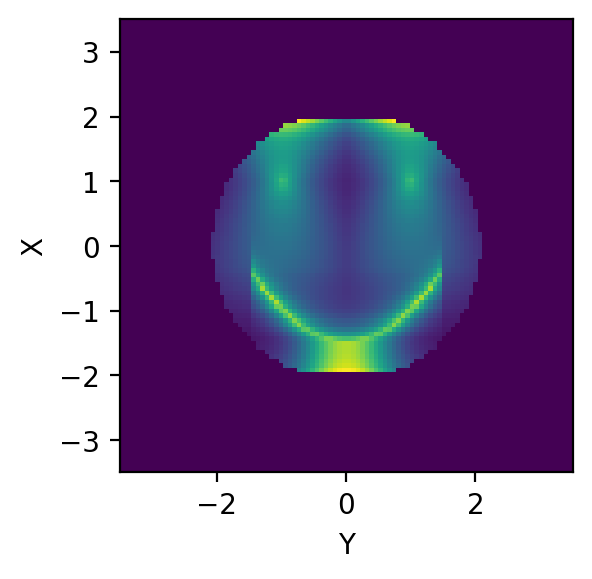

In [9]:
plt.rcParams["figure.dpi"] = 200

def face():
    def fac(Ps, x):
        eyes = torch.Tensor([[-1,1], [1,1]]).reshape(2,2) # = (2, 2)
        full_ps = torch.full_like(x, Ps[0])
        points = torch.column_stack((x, full_ps))
        # print(points.shape) # = (50, 2)
        
        # get distance from each point to each eye
        dists = torch.cdist(points, eyes) # = (50, 2)
        eye_scores = dists.min(dim=1).values # = (50)

        cutoff = 1.5
        smile_dist = torch.abs(full_ps - (0.5*(x**2)-1.5))
        mouth_dist = torch.where((-cutoff < x) & (x < cutoff), torch.exp(-smile_dist), full_ps*0)
        
        return mouth_dist**4 + torch.exp(-eye_scores)**2 * 10


    def bound(Ps):
        radius = 2.1
        height = Ps[0]

        a = sqrt(radius**2 - height**2)

        return (-a,a)
        

    return dist(fac, bound, "face")

X = "X" > uniform(-2,2)
# X = "X" > gauss(0,0.3)
Y = "Y" | pa(X) > face()


display(X.get_graph(True))


spn_sloped = spnhelp.bn_to_spn(X, marginal_target= 100, sloped=True)
info = spnhelp.get_pdf_grid_values(spn_sloped, [7, 7], [0,0], 100)
spnhelp.show_data(info)

print(get_number_of_nodes(spn_sloped))

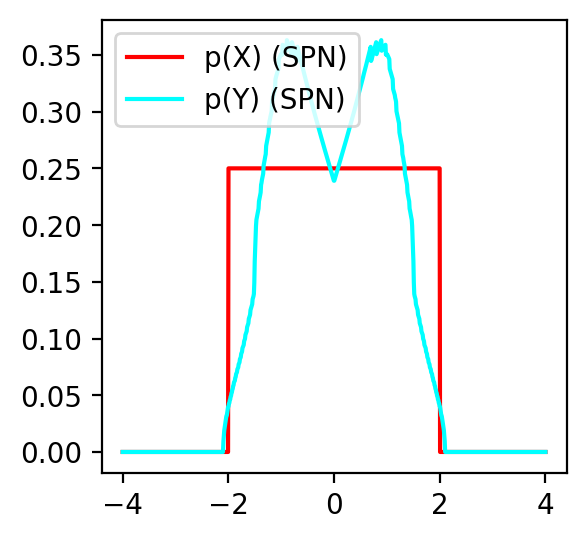

In [10]:
spnhelp.plot_marginals(spn_sloped, X, xs=np.linspace(-4, 4, 1000))
plt.legend(loc="upper left")